In [1]:
import torch
from prep_data import prep_data
from NNModel import MultiLayerNN
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
from prep_data import prep_data

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [3]:
train_loader, test_loader = prep_data()

In [4]:
torch.manual_seed(42)
model = torch.compile(MultiLayerNN(latent_size=128, num_layers=3), mode="max-autotune").to(device)

In [5]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=10)
criterion = torch.nn.CrossEntropyLoss()

In [8]:
for epoch in range(4):
    for data, labels, _ in train_loader:
        data = data.view(-1, 28*28).to(device)
        labels = labels.to(device)
        preds = model(data)
        loss = criterion(preds, labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
    scheduler.step()
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

AUTOTUNE mm(96x10, 10x128)
  triton_mm_517 0.0041 ms 100.0% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=32, BLOCK_N=32, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=2, num_warps=4
  triton_mm_520 0.0043 ms 96.2% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=64, BLOCK_N=32, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=5, num_warps=4
  triton_mm_518 0.0043 ms 95.5% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=32, BLOCK_N=64, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=5, num_warps=8
  triton_mm_519 0.0043 ms 94.8% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=64, BLOCK_N=32, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=5, num_warps=8
  triton_mm_522 0.0048 ms 85.9% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=64, BLOCK_N=64, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=3, num_warps=8
  triton_mm_523 0.0048 ms 85.9% ACC_T

Epoch 1 | Loss: 0.0609
Epoch 2 | Loss: 0.1372
Epoch 3 | Loss: 0.1289
Epoch 4 | Loss: 0.1413


W1126 22:01:45.352331 2616423 site-packages/torch/_inductor/select_algorithm.py:1696] [0/3] out of resource: shared memory, Required: 98304, Hardware limit: 65536. Reducing block sizes or `num_stages` may help.
AUTOTUNE mm(128x784, 784x128)
  mm 0.0182 ms 100.0% 
  triton_mm_683 0.0615 ms 29.5% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=128, BLOCK_M=32, BLOCK_N=32, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=2, num_warps=4
  triton_mm_682 0.0717 ms 25.4% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=16, BLOCK_M=32, BLOCK_N=32, B_PROLOGUE_CAST_TYPE=None, EVEN_K=True, GROUP_M=8, num_stages=1, num_warps=2
  triton_mm_685 0.0782 ms 23.2% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=32, BLOCK_M=64, BLOCK_N=32, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=5, num_warps=8
  triton_mm_684 0.0798 ms 22.8% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=32, BLOCK_M=32, BLOCK_N=64, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=5, 

Accuracy: 0.9672


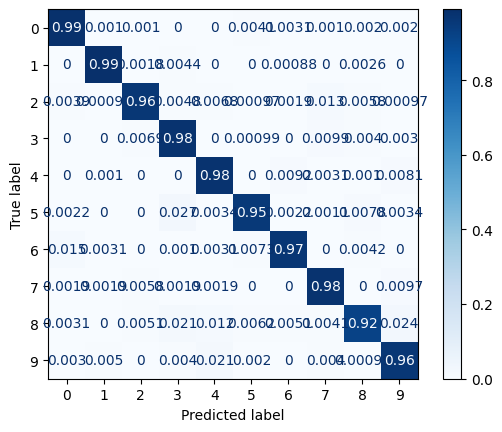

In [9]:
cm = torch.zeros(10, 10)
with torch.no_grad():
    for data, labels, _ in test_loader:
        data = data.view(-1, 28*28).to(device)
        labels = labels.to(device)
        preds = model(data)
        for i, pred in enumerate(preds):
            cm[labels[i], pred.argmax()] += 1
cm = cm.cpu().numpy()
accuracy = cm.diagonal().sum() / cm.sum()
cm = cm / cm.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
print(f"Accuracy: {accuracy:.4f}")

In [10]:
incorrect_preds = []
with torch.no_grad():
    for loader in [train_loader, test_loader]:
        for data, label, idxs in loader:
            preds = model(data.view(-1, 28*28).to(device))
            labels = torch.argmax(preds, dim=1).cpu()
            incorrect_idxs = labels != label
            incorrect_preds.extend(list(
                zip(
                    idxs[incorrect_idxs].cpu().numpy(), #index
                    labels[incorrect_idxs].cpu().numpy(), #pred label
                    label[incorrect_idxs].cpu().numpy())) #true label
            )


In [15]:
len(incorrect_preds)

1568

In [ ]:
with open("./data/incorrect_preds.pkl", "wb") as f:
    pickle.dump(incorrect_preds, f)

In [ ]:
torch.save(model.state_dict(), "./data/model.pt")